# GECCO 2025
# MAPLE: Multi-Action Program through Linear Evolution for Continuous Multi-Action Reinforcement Learning
## Quentin Vacher, Stephen Kelly, Ali Naqvi, Nicolas Beuve, Tanya Djavaherpour, Mickaël Dardaillon and Karols Desnos

This notebook uses the experiment results of the MAPLE algorithm to create and export the figures and data proposed in the MAPLE paper cited above

### Exportation of libraries and utils code

In [92]:
# Exportation of libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import csv

from scipy.stats import mannwhitneyu

In [93]:
# Utils code
def classic_format(ax1=None):
    if(ax1 != None):
        ax = ax1
    else:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)   
pd.set_option('display.max_rows', None)


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
pd.set_option("display.width", 200)

l_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Define the mapping of old column names to new column names
column_mapping = {
    "U_Min": "MinTraining",
    "U_Avg": "AvgTraining",
    "U_Max": "MaxTraining",
    "U_Min.1": "MinValidation",
    "U_Avg.1": "AvgValidation",
    "U_Max.1": "MaxValidation",
    "R_Min": "MinTrainingScore",
    "R_Avg": "AvgTrainingScore",
    "R_Max": "MaxTrainingScore",
    "R_Min.1": "MinValidationScore",
    "R_Avg.1": "AvgValidationScore",
    "R_Max.1": "MaxValidationScore",
    "Min": "MinTraining",
    "Avg": "AvgTraining",
    "Max": "MaxTraining",
    "Min.1": "MinValidation",
    "Avg.1": "AvgValidation",
    "Max.1": "MaxValidation"
}

beautifulEnvName = {
    "inverted_double_pendulum": "Inverted Double Pendulum",
    "hopper": "Hopper",
    "half_cheetah": "Half Cheetah",
    "walker2d": "Walker 2D",
    "ant": "Ant",
    "humanoid": "Humanoid"
}

### Loading the data of MAPLE, MATPG and TPG.

This three algorithms were used with the Gegelati library

In [94]:
nbSeed = 10

allEnvironments = [
    "inverted_double_pendulum",
    "hopper",
    "half_cheetah",
    "walker2d",
    "ant",
    "humanoid"
]

algo = [
    "MAPLE",
    "MATPG",
    "TPG"
]

all_data = []

for a in algo:
    for e in allEnvironments:
        for i in range(nbSeed):
            key = f"logs/{a}/{e}/out.{i}.p0.{e}.std"
            try:
                df = pd.read_csv(key, sep=r'\s+', skiprows=1)
                df = df.dropna()

                # Add algorithm, environment, and seed columns
                df['algorithm'] = a
                df['environment'] = e
                df['seed'] = i
                
                # Rename the columns using the mapping
                df = df.rename(columns=column_mapping)
                all_data.append(df)
            except Exception as ex:
                print(f"Error reading {key}", end="\r")
print(len(all_data))

# Concatenate all into a single DataFrame
df = pd.concat(all_data, ignore_index=True)

160or reading logs/TPG/humanoid/out.9.p0.humanoid.stdetah.std


In [95]:
df.describe()

,Gen,NbVert,NbActR,NbTeamR,MinTraining,AvgTraining,MaxTraining,MinValidation,AvgValidation,MaxValidation,T_mutat,T_eval,T_valid,T_decim,T_total,seed,MinTrainingScore,AvgTrainingScore,MaxTrainingScore,MinValidationScore,AvgValidationScore,MaxValidationScore
count,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.00000,8630.000000,8630.000000,8630.000000,8630.00000,8630.000000,8630.000000,8630.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000,4734.000000
mean,946.909270,1836.415527,624.921321,375.108575,-201.560082,1743.225051,4095.757842,68.688385,2841.25987,4020.340175,1.774824,18.104207,57.19120,1.595410,23500.231092,4.471263,-360.323255,371.444453,919.409512,-92.573925,634.481432,851.134347
std,990.188007,1358.207114,389.511240,389.539608,769.367011,1849.638523,3502.259619,547.166093,2750.65287,3528.174125,5.177834,20.032001,58.37663,3.031004,31758.341640,2.849702,735.408688,328.323743,714.744941,257.994997,511.655575,684.726738
min,0.000000,1000.000000,0.000000,0.000000,-3764.160000,-1287.990000,-0.080000,-2247.190000,-819.25000,-0.350000,0.000000,0.150000,0.26000,0.010000,0.680000,0.000000,-4016.840000,-1089.860000,-4.070000,-3048.790000,-637.880000,-0.060000
25%,250.000000,1000.000000,0.000000,0.000000,-36.242500,559.545000,1359.967500,13.987500,864.30250,1224.347500,0.540000,3.732500,15.44250,0.180000,1515.875000,2.000000,-200.340000,71.432500,142.902500,-63.812500,106.450000,130.105000
50%,500.000000,1865.000000,667.000000,333.000000,26.840000,1061.750000,2446.300000,46.010000,1744.36000,2357.770000,1.280000,10.010000,36.77000,0.410000,9152.745000,4.000000,-40.900000,332.045000,923.030000,-4.620000,660.690000,835.835000
75%,1400.000000,1950.000000,1000.000000,1000.000000,123.185000,1674.035000,9358.040000,202.900000,3226.77250,9056.340000,1.830000,24.270000,80.36750,1.570000,35347.475000,7.000000,-29.710000,600.125000,1404.442500,8.170000,993.097500,1293.947500
max,4999.000000,18996.000000,1000.000000,1002.000000,969.040000,8531.910000,9360.000000,8751.840000,9358.35000,9360.000000,98.500000,159.030000,461.70000,43.590000,198906.410000,9.000000,-4.760000,1475.210000,2592.600000,828.350000,2168.400000,2568.710000


### Raw results of MAPLE, MATPG and TPG on the MuJoCo suite

In [96]:
# Get last generation
def get_last_generation(group):
    return group[group['Gen'] == group['Gen'].max()]

# Get last generations
last_generations = df.groupby(['algorithm', 'environment', 'seed']).apply(get_last_generation).reset_index(drop=True)

results = last_generations.groupby(['algorithm', 'environment'])['MaxValidation'].agg(['mean', 'std', 'median']).reset_index()
results = results.rename(columns={'mean': 'Mean', 'std': 'Standard Deviation', 'median': 'Median'})

print(results)

   algorithm               environment         Mean  Standard Deviation    Median
0      MAPLE              half_cheetah  2690.367000          226.310375  2779.605
1      MAPLE                    hopper  2832.430000          508.765421  2903.440
2      MAPLE                  humanoid   806.615000          116.025771   845.290
3      MAPLE  inverted_double_pendulum  9359.908000            0.280468  9360.000
4      MAPLE                  walker2d  2504.958000          528.008480  2299.785
5      MATPG                       ant  2053.318000          291.978504  2136.490
6      MATPG              half_cheetah  2844.641000          274.378828  2812.580
7      MATPG                    hopper  3027.149000          349.568072  3096.175
8      MATPG                  humanoid   745.506000          127.965599   754.825
9      MATPG  inverted_double_pendulum  9359.995000            0.005270  9359.995
10     MATPG                  walker2d  2461.733000          498.400232  2558.170
11       TPG    

C:\Users\qvacher\AppData\Local\Temp\ipykernel_23956\3954940326.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_generations = df.groupby(['algorithm', 'environment', 'seed']).apply(get_last_generation).reset_index(drop=True)


### Visualisation of the training curves of MAPLE, MATPG and TPG on each MuJoCo environment

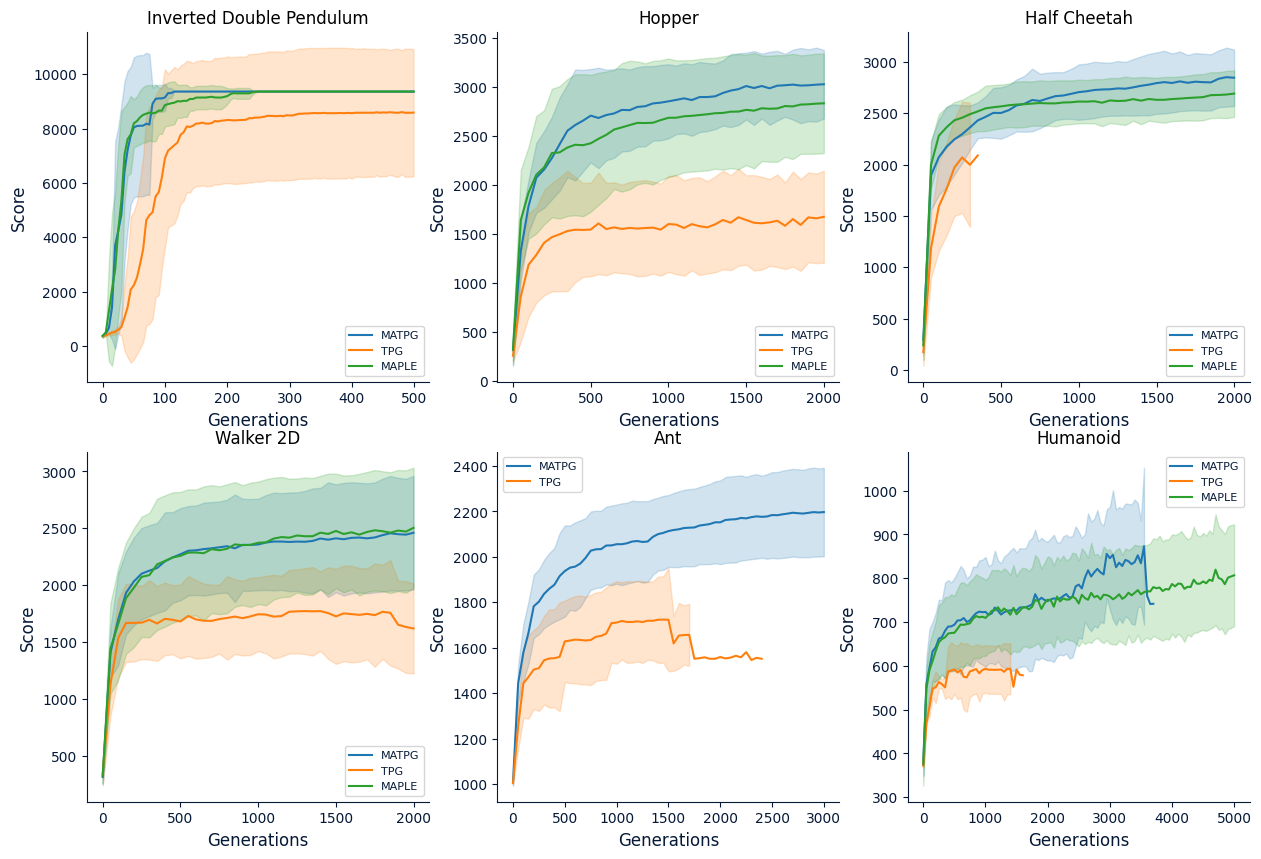

In [97]:
xVal = 'Gen'
yVal = 'MaxValidation'

average_df = df.groupby(['environment', 'algorithm', xVal])[yVal].agg(['mean', 'std', 'median']).reset_index()

max_wanted = True
func1, func2, text = (np.amax, np.argmax, "Max") if max_wanted else (np.amin, np.argmin, "Min")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# One graphic per environment
for i, (env, ax) in enumerate(zip(allEnvironments, axs.flat)):
    ax.set_title(beautifulEnvName[env])
    indexColor = 0

    for algo in average_df['algorithm'].unique():
        subset = average_df[(average_df['environment'] == env) & (average_df['algorithm'] == algo)]
        if not subset.empty:
            ax.plot(subset[xVal], subset['mean'], label=algo, color=l_colors[indexColor])
            ax.fill_between(subset[xVal], subset['mean'] - subset['std'], subset['mean'] + subset['std'], color=l_colors[indexColor], alpha=0.2)
            indexColor+=1

    classic_format(ax)
    colorAxe = "#051937"
    ax.spines['bottom'].set_color(colorAxe)
    ax.spines['left'].set_color(colorAxe)

    ax.set_xlabel("Generations", fontsize=12, color=colorAxe)
    ax.set_ylabel("Score", fontsize=12, color=colorAxe)
    ax.tick_params(axis='x', labelsize=10, colors=colorAxe)
    ax.tick_params(axis='y', labelsize=10, colors=colorAxe)
    ax.legend(fontsize=8, labelcolor=colorAxe)


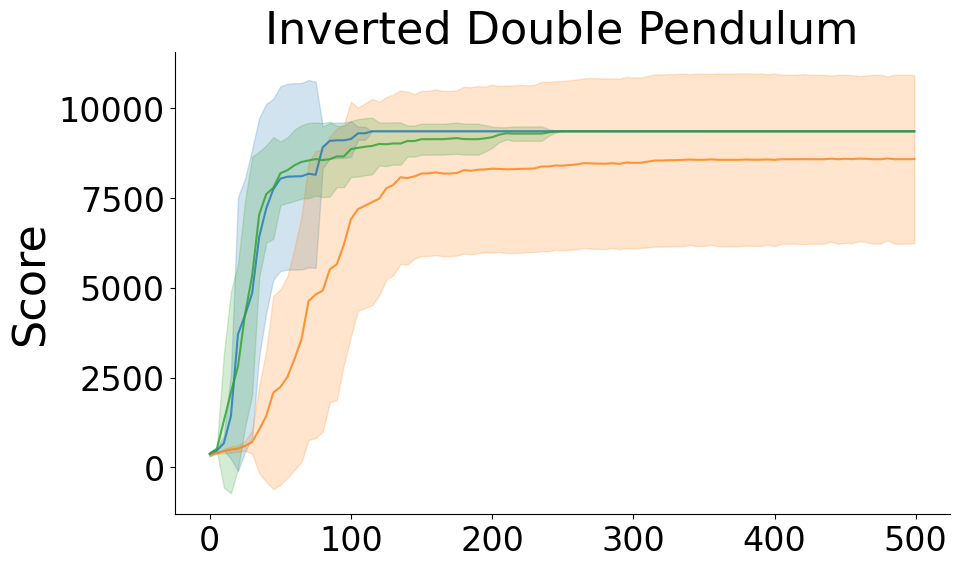

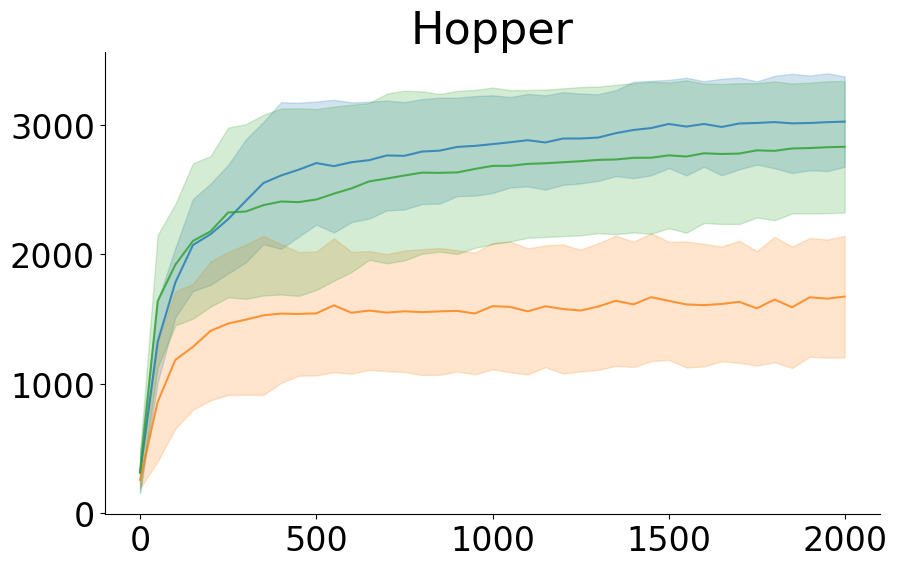

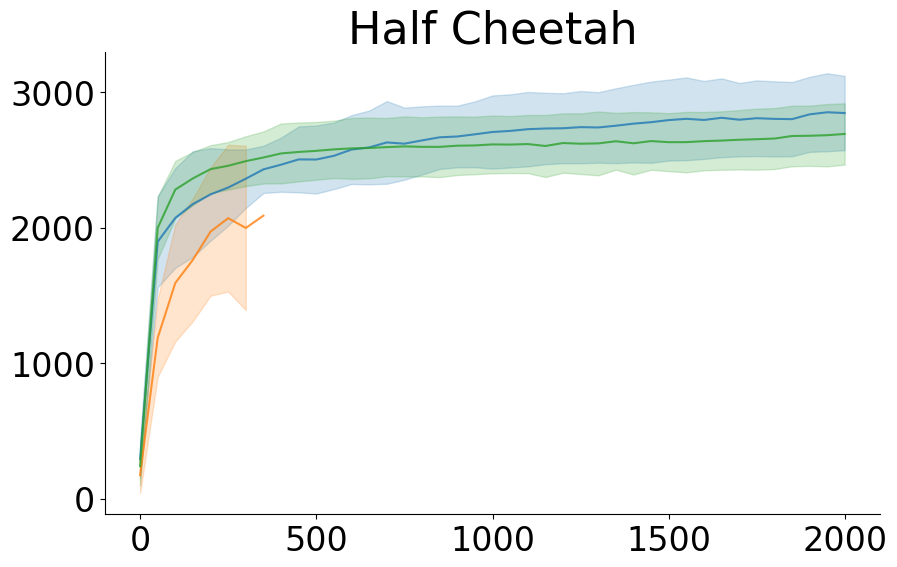

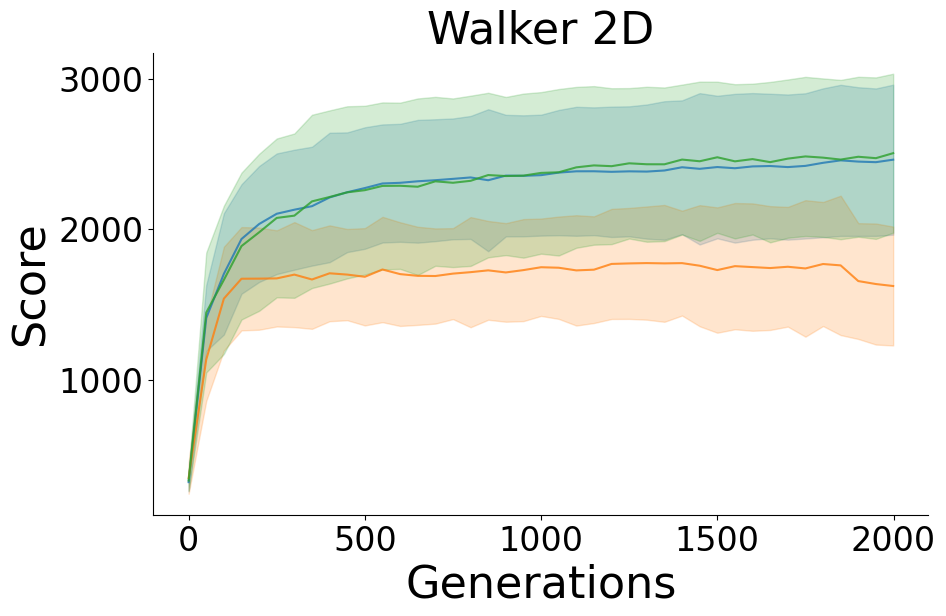

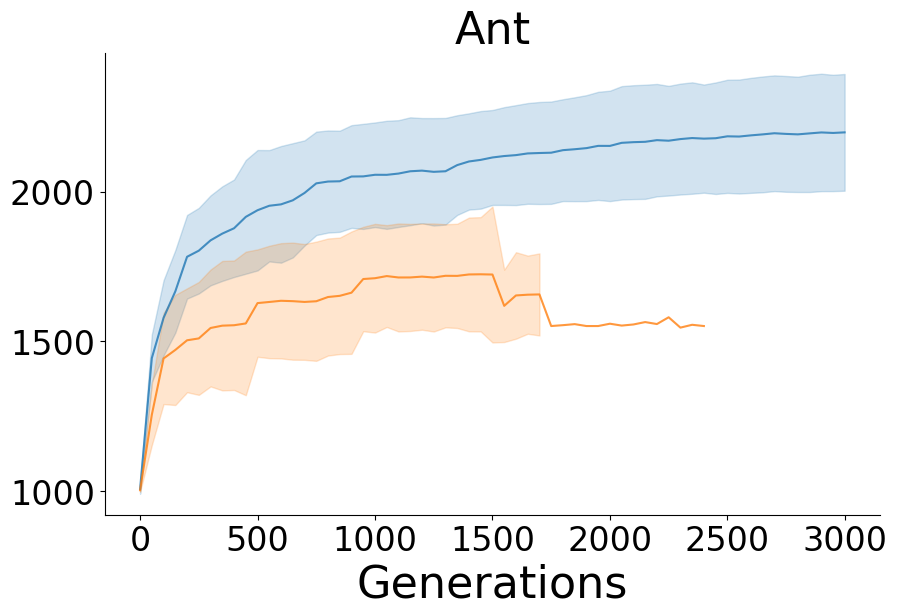

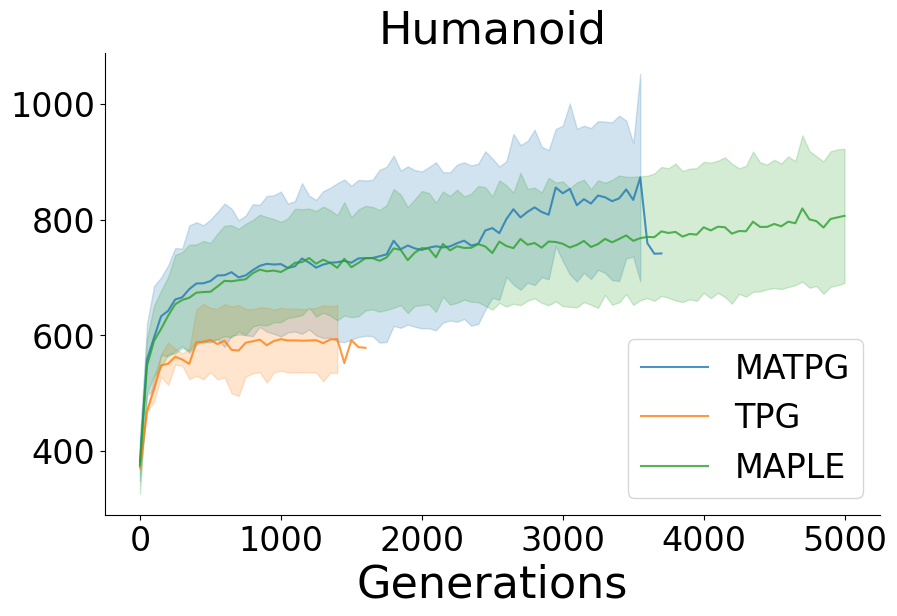

In [98]:
xVal = 'Gen'
yVal = 'MaxValidation'
max_wanted = True
func1, func2, text = (np.amax, np.argmax, "Max") if max_wanted else (np.amin, np.argmin, "Min")

# For each environment
for indexEnv, env in enumerate(allEnvironments):
    plt.figure(figsize=(10,6))
    ax = plt.gca()
    indexColor = 0

    for algo in average_df['algorithm'].unique():
        subset = average_df[(average_df['environment'] == env) & (average_df['algorithm'] == algo)]
        if not subset.empty:
            x = subset[xVal]
            y_mean = subset['mean']
            y_std = subset['std']

            plt.plot(x, y_mean, label=algo, color=l_colors[indexColor], alpha=0.8)
            plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=l_colors[indexColor], alpha=0.2)


            indexColor += 1

    classic_format()    
    colorAxe = "black"
    ax.spines['bottom'].set_color(colorAxe)
    ax.spines['left'].set_color(colorAxe)

    if indexEnv > 2:
        plt.xlabel("Generations", fontsize=32, color=colorAxe)
    else:
        plt.xlabel("", fontsize=1, color=colorAxe)

    if indexEnv % 3 == 0:
        plt.ylabel("Score", fontsize=32, color=colorAxe)
    else:
        plt.ylabel("", fontsize=1, color=colorAxe)

    if indexEnv == 5:
        plt.legend(fontsize=24, labelcolor=colorAxe)

    plt.tick_params(axis='x', labelsize=24, colors=colorAxe)
    plt.tick_params(axis='y', labelsize=24, colors=colorAxe)
    plt.title(beautifulEnvName[env], fontsize=32, color=colorAxe)

    plt.savefig(f'exported_results/scoreMAPLE_{env}.pdf', format="pdf", dpi=100, transparent=True, bbox_inches='tight')
    plt.show()


### Loading data of PPO and SAC, and then LGP on the MuJoCo tasks

The PPO and SAC results were optained with stable baseline 3

The LGP results are directly imported from **Giorgia Nadizar, Eric Medvet, and Dennis G Wilson. 2024. Naturally Interpretable
Control Policies via Graph-Based Genetic Programming. In European Conference
on Genetic Programming**

In [99]:
data_PPO = {
    "inverted_double_pendulum": [],
    "hopper": [],
    "half_cheetah": [],
    "walker2d": [],
    "ant": [],
    "humanoid": [],
}
data_SAC = {
    "inverted_double_pendulum": [],
    "hopper": [],
    "half_cheetah": [],
    "walker2d": [],
    "ant": [],
    "humanoid": [],
}

# To convert environment names
env_key_mapping = {
    "InvertedDoublePendulum-v4": "inverted_double_pendulum",
    "Hopper-v4": "hopper",
    "HalfCheetah-v4": "half_cheetah",
    "Walker2d-v4": "walker2d",
    "Ant-v4": "ant",
    "Humanoid-v4": "humanoid",
}

# Lecture des données depuis le fichier CSV
csv_file = "deep_rl_data/sumup_rl_results.csv"

with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        env_name = env_key_mapping.get(row["Env_Name"], None)
        algorithm = row["Algorithm"].lower()
        average_reward = float(row["Average_Reward"])

        # Ajouter la récompense au bon algorithme et environnement
        if env_name:
            if algorithm == "ppo":
                data_PPO[env_name].append(average_reward)
            elif algorithm == "sac":
                data_SAC[env_name].append(average_reward)

# Affichage des données mises à jour
print("Data PPO:", data_PPO)
print("Data SAC:", data_SAC)

Data PPO: {'inverted_double_pendulum': [9359.503108453751, 7225.216445779801, 890.6827063083649, 3560.9342302799223, 9359.65712776184, 9358.896872377396, 9359.48329963684, 9318.940423679353, 1122.852437543869, 7574.585127210617], 'hopper': [1713.5722342789172, 1966.9598010540008, 1879.8842046886682, 1907.4964781522751, 2444.4268678307535, 1869.9835380911827, 1362.1398922473193, 1417.9812621593476, 1205.6960405230523, 1887.7517727673053], 'half_cheetah': [1823.1766232578946, 1797.8961716041638, 1738.9434248471516, 1866.5936647130197, 1805.5929003216795, 1818.853760759203, 1597.9652597891284, 3094.9362720522745, 1910.692683456928, 1859.2530949499312], 'walker2d': [3226.7342692166567, 478.230696195364, 4124.725275054574, 4488.4607364833355, 762.3473511487246, 1239.091882121563, 4452.9948929905895, 4566.03332130909, 2697.6529005646707, 3912.823298278451], 'ant': [5911.371314107021, 5462.9743680841875, 5346.3975872140845, 3921.343764298188, 4918.894451290369, 5901.6705402277175, 5256.904568

In [100]:
# Data from Nadizar paper on LGP.
data_LGP = {
    "half_cheetah": [6401.04345703125, 6532.55078125, 6097.98388671875, 6575.6025390625, 6169.09765625, 6727.05322265625, 6567.09912109375, 6931.47802734375, 6373.47021484375, 4681.67431640625],
    "hopper": [1087.8963623046875, 1348.1890869140625, 1126.781494140625, 1263.3856201171875, 1141.8143310546875, 1338.2640380859375, 1123.2767333984375, 1047.4007568359375, 1118.4427490234375, 1080.1868896484375],
    "inverted_double_pendulum": [9455.7724609375, 9484.845703125, 9412.7041015625, 9472.5517578125, 9341.8974609375, 9286.3720703125, 9421.6337890625, 9438.5732421875, 9363.98828125, 9496.0537109375],
    "ant": [1023.5964965820312, 1626.9891357421875, 1211.2357177734375, 1219.8675537109375, 1490.741943359375, 1217.9986572265625, 1217.7010498046875, 1034.7437744140625, 1409.8453369140625, 1491.4927978515625],
    "walker2d": [1133.5540771484375, 1121.1778564453125, 1136.4681396484375, 979.43212890625, 1142.1771240234375, 1122.7728271484375, 1193.9232177734375, 982.2586059570312, 1125.2513427734375, 1146.8472900390625],
    "humanoid": [np.nan]
}

In [ ]:
# Assurez-vous que la colonne MaxValidation est bien numérique
df['MaxValidation'] = pd.to_numeric(df['MaxValidation'], errors='coerce')

# Supprimer les NaN potentiels
df = df.dropna(subset=['MaxValidation'])

# Obtenir la dernière ligne pour chaque seed/env/algo
last_values_df = df.sort_values('Gen').groupby(['algorithm', 'environment', 'seed']).tail(1)

# Garder uniquement les colonnes utiles (vous pouvez en ajouter d'autres si besoin)
df_All_Score = last_values_df[['algorithm', 'environment', 'seed', 'MaxValidation']].reset_index(drop=True)

In [ ]:

# Fonction pour convertir les dictionnaires en DataFrame
def convert_dict_to_df(data_dict, algo_name):
    records = []
    for env, rewards in data_dict.items():
        for seed, reward in enumerate(rewards):
            records.append({
                "algorithm": algo_name,
                "environment": env,
                "seed": seed,
                "MaxValidation": reward  # Tu peux changer le nom ici si besoin
            })
    return pd.DataFrame(records)

# Convertir PPO et SAC en DataFrame
ppo_df = convert_dict_to_df(data_PPO, "PPO")
sac_df = convert_dict_to_df(data_SAC, "SAC")

# Concaténer avec le DataFrame existant
df_All_Score = pd.concat([df_All_Score, ppo_df, sac_df], ignore_index=True)


In [ ]:
# Fonction pour convertir le dictionnaire LGP en DataFrame
def convert_lgp_to_df(data_dict):
    records = []
    for env, rewards in data_dict.items():
        for seed, reward in enumerate(rewards):
            records.append({
                "algorithm": "LGP",
                "environment": env,
                "seed": seed,
                "MaxValidation": reward
            })
    return pd.DataFrame(records)

# Conversion
lgp_df = convert_lgp_to_df(data_LGP)

# Concaténation
df_All_Score = pd.concat([df_All_Score, lgp_df], ignore_index=True)

# Afficher un aperçu
df_All_Score.describe(include='all')

,algorithm,environment,seed,MaxValidation
count,331,331,331.000000,330.000000
unique,6,6,NaN,NaN
top,MATPG,walker2d,NaN,NaN
freq,60,60,NaN,NaN
mean,NaN,NaN,4.435045,3712.955296
std,NaN,NaN,2.878001,2972.178264
min,NaN,NaN,0.000000,453.143387
25%,NaN,NaN,2.000000,1480.554083
50%,NaN,NaN,4.000000,2550.634375
75%,NaN,NaN,7.000000,5433.830173


### Printing boxplot of each algorithm on each of the MuJoCo environment

C:\Users\qvacher\AppData\Local\Temp\ipykernel_23956\3405530842.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(boxplot_data, positions=positions, labels=labels, vert=True, patch_artist=True, flierprops=dict(marker='o', markersize=8))
C:\Users\qvacher\AppData\Local\Temp\ipykernel_23956\3405530842.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(boxplot_data, positions=positions, labels=labels, vert=True, patch_artist=True, flierprops=dict(marker='o', markersize=8))
C:\Users\qvacher\AppData\Local\Temp\ipykernel_23956\3405530842.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3

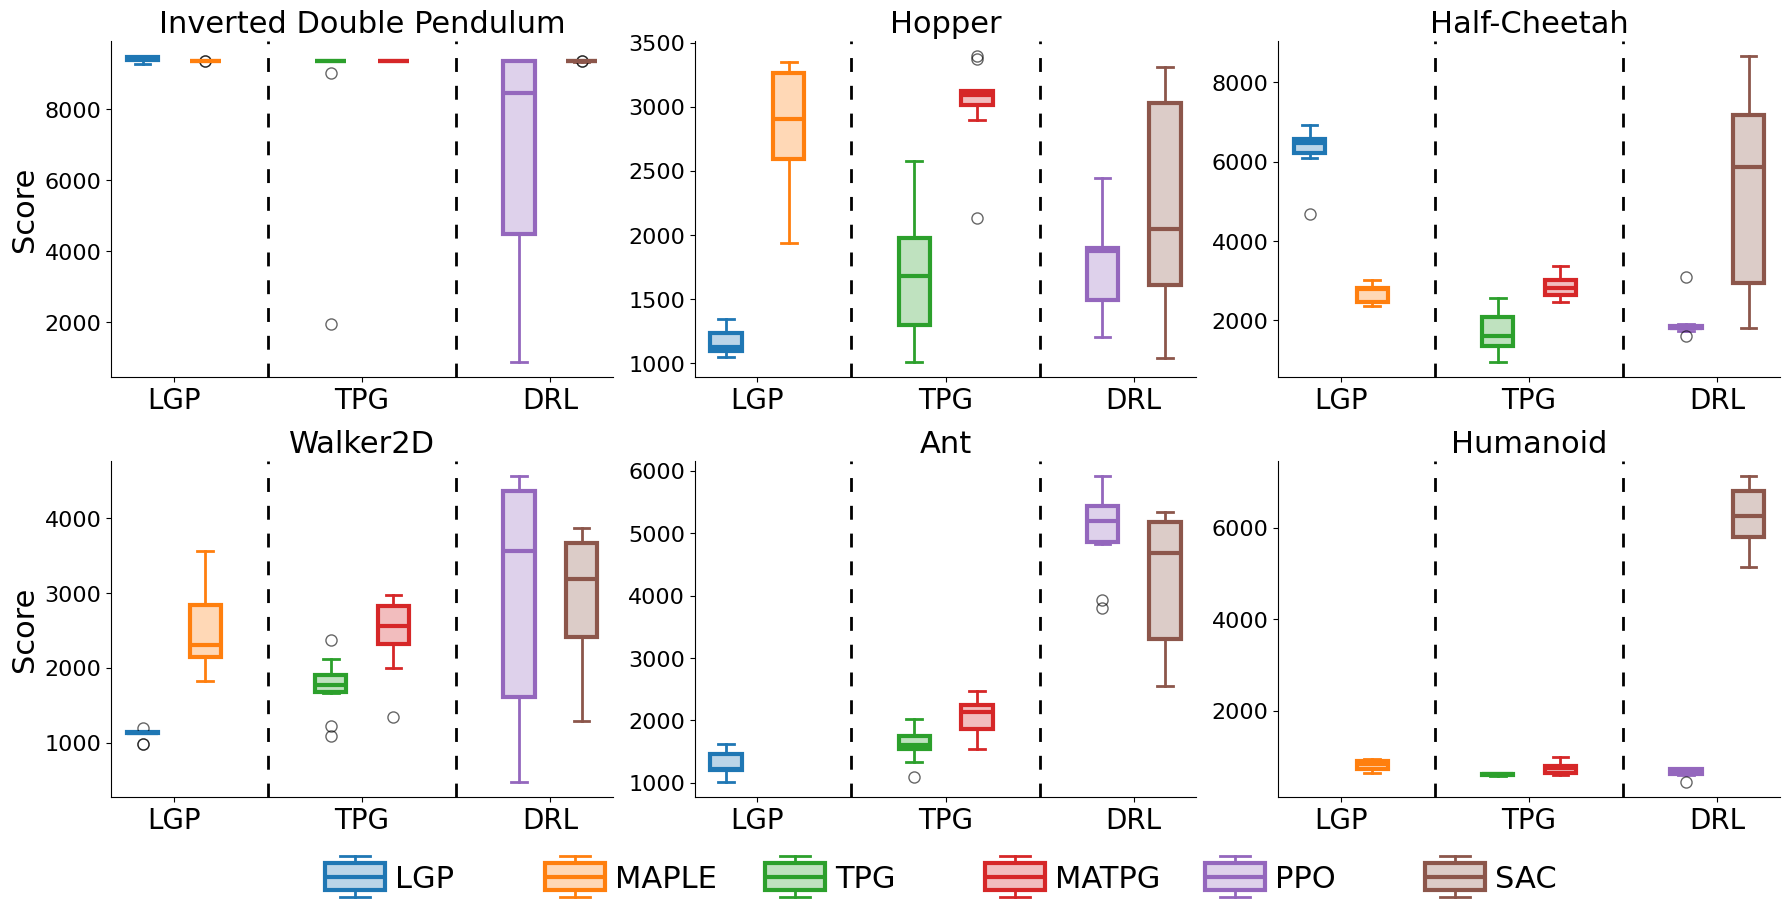

In [ ]:
# Environnements et labels
envs = ["inverted_double_pendulum", "hopper", "half_cheetah", "walker2d", "ant", "humanoid"]
labels = ["LGP", "MAPLE", "TPG", "MATPG", "PPO", "SAC"]
grouped_labels = ["LGP", "TPG", "DRL"]

# Mapping noms jolis
beautifulEnvName = {
    "inverted_double_pendulum": "Inverted Double Pendulum",
    "hopper": "Hopper",
    "half_cheetah": "Half-Cheetah",
    "walker2d": "Walker2D",
    "ant": "Ant",
    "humanoid": "Humanoid"
}

# Couleurs
colors = {
    "LGP": "#1f77b4",
    "MAPLE": "#ff7f0e",
    "TPG": "#2ca02c",
    "MATPG": "#d62728",
    "PPO": "#9467bd",
    "SAC": "#8c564b"
}

# Subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

for idx, env_name in enumerate(envs):
    ax = axes[idx]
    boxplot_data = []

    for algo in ["LGP", "MAPLE", "TPG", "MATPG", "PPO", "SAC"]:
        vals = df_All_Score[
            (df_All_Score["algorithm"] == algo) &
            (df_All_Score["environment"] == env_name)
        ]["MaxValidation"].dropna().tolist()

        boxplot_data.append(vals if len(vals) > 0 else [np.nan])

    positions = [1, 2, 4, 5, 7, 8]
    bplot = ax.boxplot(boxplot_data, positions=positions, labels=labels, vert=True, patch_artist=True, flierprops=dict(marker='o', markersize=8))

    # Coloration
    for patch, label in zip(bplot['boxes'], labels):
        rgba = mcolors.to_rgba(colors[label], alpha=0.3)
        patch.set_facecolor(rgba)
        patch.set_edgecolor(colors[label])
        patch.set_linewidth(3)

    for key in ['whiskers', 'caps', 'medians', 'fliers']:
        for i, item in enumerate(bplot[key]):
            algo_index = i // 2 if key in ['whiskers', 'caps'] else i
            algo_label = labels[algo_index]
            item.set_color(colors[algo_label])
            item.set_linewidth(2 if key != 'medians' else 3)
            if key == 'fliers':
                item.set_alpha(0.6)

    # Separators
    ax.axvline(x=3, color="black", linestyle="--", linewidth=2, dashes=(5, 5))
    ax.axvline(x=6, color="black", linestyle="--", linewidth=2, dashes=(5, 5))

    ax.set_xticks([1.5, 4.5, 7.5])
    ax.set_xticklabels(grouped_labels, fontsize=14)

    ax.set_title(beautifulEnvName[env_name], fontsize=22, color="black")
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=20, colors="black")
    ax.tick_params(axis='y', labelsize=16, colors="black")

    if idx % 3 == 0:
        ax.set_ylabel("Score", fontsize=22, color="black")

# ----------- Custom Legend ----------------
legend_ax = fig.add_axes([0.1, -0.055, 0.8, 0.05])
simulated_data = [0.9, 0.6, 0, -0.6, -0.9]

for i, (label, color) in enumerate(colors.items()):
    bplot = legend_ax.boxplot([simulated_data], positions=[i * 1.1 + 0.9], vert=True, patch_artist=True,
                              widths=0.3, flierprops=dict(marker='o', markersize=4))

    for patch in bplot['boxes']:
        patch.set_facecolor(mcolors.to_rgba(color, alpha=0.3))
        patch.set_edgecolor(color)
        patch.set_linewidth(3)

    for key in ['whiskers', 'caps', 'medians', 'fliers']:
        for item in bplot[key]:
            item.set_color(color)
            item.set_linewidth(2 if key != 'medians' else 3)
            if key == 'fliers':
                item.set_alpha(0.6)

    legend_ax.text(i * 1.1 + 1.1, -0.1, label, fontsize=22, va='center', ha='left', color='black')

legend_ax.set_xlim(0, len(colors) * 1.2)
legend_ax.set_ylim(-1, 1)
legend_ax.axis('off')

# Layout final
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('exported_results/comparisonBoxPlot.pdf', format="pdf", dpi=100, transparent=True, bbox_inches='tight')
plt.show()


### Use of Mann-Whitney U tests to evaluate is the two propose algorithm, MAPLE and MATPG, are significant

Evaluation for MAPLE

In [ ]:


# Initialisation des résultats des tests
results = []

for e in df_All_Score['environment'].unique():
    env_data = df_All_Score[df_All_Score['environment'] == e]
    
    # Comparaison MAPLE avec tous les autres algorithmes
    maple_scores = env_data[env_data['algorithm'] == 'MAPLE']['MaxValidation'].astype(float)
    
    for other_algo in ['LGP', 'TPG', 'MATPG', 'PPO', 'SAC']:
        other_algo_scores = env_data[env_data['algorithm'] == other_algo]['MaxValidation'].astype(float)
        
        # Vérifiez la taille minimale des distributions
        if len(maple_scores) < 2 or len(other_algo_scores) < 2:
            print(f"Skipping test for MAPLE vs {other_algo} in environment {e} due to insufficient data.")
            continue
        
        # Test de Mann-Whitney
        stat, p_value = mannwhitneyu(maple_scores, other_algo_scores, alternative='two-sided')
        results.append({
            'environment': e,
            'algo1': 'MAPLE',
            'algo2': other_algo,
            'stat': stat,
            'p_value': p_value
        })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Ajouter une colonne 'is_significant' qui est True si p-value ajustée < 0.05, sinon False
results_df['is_significant'] = results_df['p_value'] < 0.005

# Afficher le DataFrame avec la nouvelle colonne
print(results_df)

results_df.to_csv('exported_results/mann_whitney_maple.csv', index=False)  # index=False pour ne pas inclure l'index dans le fichier

Skipping test for MAPLE vs LGP in environment ant due to insufficient data.
Skipping test for MAPLE vs TPG in environment ant due to insufficient data.
Skipping test for MAPLE vs MATPG in environment ant due to insufficient data.
Skipping test for MAPLE vs PPO in environment ant due to insufficient data.
Skipping test for MAPLE vs SAC in environment ant due to insufficient data.
Skipping test for MAPLE vs LGP in environment humanoid due to insufficient data.
                 environment  algo1  algo2   stat   p_value  is_significant
0               half_cheetah  MAPLE    LGP    0.0  0.000183            True
1               half_cheetah  MAPLE    TPG   86.0  0.000944            True
2               half_cheetah  MAPLE  MATPG   33.0  0.212294           False
3               half_cheetah  MAPLE    PPO   90.0  0.002827            True
4               half_cheetah  MAPLE    SAC   30.0  0.140465           False
5   inverted_double_pendulum  MAPLE    LGP   20.0  0.022698           False
6   i

Evaluation for MATPG

In [ ]:
# Initialisation des résultats des tests
results = []

for e in df_All_Score['environment'].unique():
    env_data = df_All_Score[df_All_Score['environment'] == e]
    
    # Comparaison MAPLE avec tous les autres algorithmes
    maple_scores = env_data[env_data['algorithm'] == 'MATPG']['MaxValidation'].astype(float)
    
    for other_algo in ['LGP', 'TPG', 'MAPLE', 'PPO', 'SAC']:
        other_algo_scores = env_data[env_data['algorithm'] == other_algo]['MaxValidation'].astype(float)
        
        # Vérifiez la taille minimale des distributions
        if len(maple_scores) < 2 or len(other_algo_scores) < 2:
            print(f"Skipping test for MATPG vs {other_algo} in environment {e} due to insufficient data.")
            continue
        
        # Test de Mann-Whitney
        stat, p_value = mannwhitneyu(maple_scores, other_algo_scores, alternative='two-sided')
        results.append({
            'environment': e,
            'algo1': 'MATPG',
            'algo2': other_algo,
            'stat': stat,
            'p_value': p_value
        })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Ajouter une colonne 'is_significant' qui est True si p-value ajustée < 0.05, sinon False
results_df['is_significant'] = results_df['p_value'] < 0.005

# Afficher le DataFrame avec la nouvelle colonne
print(results_df)

results_df.to_csv('exported_results/mann_whitney_matpg.csv', index=False)  # index=False pour ne pas inclure l'index dans le fichier

Skipping test for MATPG vs MAPLE in environment ant due to insufficient data.
Skipping test for MATPG vs LGP in environment humanoid due to insufficient data.
                 environment  algo1  algo2   stat   p_value  is_significant
0               half_cheetah  MATPG    LGP    0.0  0.000183            True
1               half_cheetah  MATPG    TPG   89.0  0.000383            True
2               half_cheetah  MATPG  MAPLE   67.0  0.212294           False
3               half_cheetah  MATPG    PPO   92.0  0.001706            True
4               half_cheetah  MATPG    SAC   30.0  0.140465           False
5                        ant  MATPG    LGP   99.0  0.000246            True
6                        ant  MATPG    TPG   78.0  0.007963           False
7                        ant  MATPG    PPO    0.0  0.000183            True
8                        ant  MATPG    SAC    0.0  0.000183            True
9   inverted_double_pendulum  MATPG    LGP   20.0  0.023556           False
10  i

## Generation of the video, codeGen, data about the best solution

For that, we will start by compiling the project (Should already be compiled, but just in case, compile again).

Make sure that the gegelati and mujoco library have been installed.



The OS used by the notebook and your compiler should be the same too.

In [ ]:
import os
import subprocess
import sys

main_dir = "gegelati-apps/mujoco/"
bin_dir = main_dir + "bin"

def run_command(command, cwd=None, verbose=True):
    if(verbose):
        print(f"\n> Executing: {' '.join(command)}")

    stdout = None if verbose else subprocess.DEVNULL
    stderr = None if verbose else subprocess.DEVNULL

    result = subprocess.run(command, cwd=cwd, stdout=stdout, stderr=stderr)
    if result.returncode != 0:
        print(f"Command failed: {' '.join(command)}")
        sys.exit(result.returncode)

### Code generation of the solutions

In [ ]:
# Configuration
nbSeed = 10

allEnvironments = [
    "inverted_double_pendulum",
    "hopper",
    "half_cheetah",
    "walker2d",
    "ant",
    "humanoid"
]

algo = [
    "MAPLE",
    "MATPG",
    "TPG"
]

testSeed = 123456789

# Exécution
totalNbRuns = len(algo) * len(allEnvironments) * nbSeed
nbRunned = 0

for a in algo:
    for e in allEnvironments:
        for i in range(nbSeed):

            print(f"Running {nbRunned + 1}/{totalNbRuns}: {a} - {e} - seed {i}", end='\r')

            cmd = [
                "./bin/Release/renderMujoco",
                "-d", f"../../logs/{a}/{e}/out_best.{i}.p0.{e}.dot",
                "-p", f"../../logs/{a}/{e}/exported_params.{e}.p0.json",
                "-c", "1",
                "-v", "2",
                "-u", f"{e}",
                "-s", f"{testSeed}",
            ]

            try:
                run_command(cmd, cwd=main_dir, verbose=False)
            except RuntimeError as err:
                print(f"\n{err}")
                print(f"Error with algo={a}, env={e}, seed={i}")

            nbRunned += 1


FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

### Generate video result for each test

It takes a loot of time, you should reduce to generate only some behaviors

In [ ]:

nbSeed = 10

allEnvironments = [
    "inverted_double_pendulum",
    "hopper",
    "half_cheetah",
    "walker2d",
    "ant",
    "humanoid"
]

algo = [
    "MAPLE",
    "MATPG",
    "TPG"
]

allEnvironments = ["ant"]
algo = ["MAPLE"]

testSeed = 123456789

# Exécution
totalNbRuns = len(algo) * len(allEnvironments) * nbSeed
nbRunned = 0

run_command(["./scripts/scriptServerMujoco.sh"], cwd=main_dir)

os.environ["DISPLAY"] = ":0"

for a in algo:
    for e in allEnvironments:
        for i in range(nbSeed):

            print(f"Running {nbRunned + 1}/{totalNbRuns}: {a} - {e} - seed {i}", end='\r')

            cmd = [
                "./bin/Release/renderMujoco",
                "-d", f"../../logs/{a}/{e}/out_best.{i}.p0.{e}.dot",
                "-p", f"../../logs/{a}/{e}/exported_params.{e}.p0.json",
                "-f", "1",
                "-g", "../../videoResults/",
                "-u", f"{e}",
                "-s", f"{testSeed}",
            ]

            try:
                run_command(cmd, cwd=main_dir, verbose=True)
            except RuntimeError as err:
                print(f"\n{err}")
                print(f"Error with algo={a}, env={e}, seed={i}")

            nbRunned += 1


### Print behavior of an agent

Select an agent by selecting
 - Algorithm
 - Environment
 - Seed

The script will run this agent for 20 episodes, will save the state and action values and print the correlation information.

In [ ]:

nbEpisode = 20

selectedSeed = 5
env = "ant"
algo = "MAPLE"

testSeed = 123456789

for i in range(nbEpisode):

    print(f"Running {i + 1}/{nbEpisode}: {a} - {e} - seed {i}", end='\r')


    cmd = [
        "./bin/Release/renderMujoco",
        "-d", f"../../logs/{algo}/{env}/out_best.{selectedSeed}.p0.{env}.dot",
        "-p", f"../../logs/{algo}/{env}/exported_params.{env}.p0.json",
        "-v", "2",
        "-u", f"{env}",
        "-s", f"{testSeed + i}",
    ]

    try:
        run_command(cmd, cwd=main_dir, verbose=False)
    except RuntimeError as err:
        print(f"\n{err}")
        print(f"Error with algo={a}, env={e}, seed={i}")

    nbRunned += 1




            

Load state and action csv files

Register the usage of sensors by each actions (would be complex to do automaticaly)

Print the correlations between states and actions